## CNN BASELINE MODEL

In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [2]:
import json

import numpy as np
import pandas as pd
import keras
from keras.callbacks import Callback
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


### 1.Loading 224x224 dataset

In [3]:
X_train = np.load('/home/zxt/data/32/7k/X_train.npy')
X_validate = np.load('/home/zxt/data/32/7k/X_validate.npy')
X_test = np.load('/home/zxt/data/32/7k/X_test.npy')
Y_train = np.load('/home/zxt/data/32/7k/Y_train.npy')
Y_validate = np.load('/home/zxt/data/32/7k/Y_validate.npy')
Y_test = np.load('/home/zxt/data/32/7k/Y_test.npy')

In [4]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_validate.shape[0], 'validate samples')
print(X_test.shape[0], 'test samples')

X_train shape: (98000, 32, 32, 3)
98000 train samples
29400 validate samples
12600 test samples


In [6]:
# Convert the images to float and scale it to a range of 0 to 1
# x_train = X_train.astype('float32')
# x_validate = X_validate.astype('float32')
# x_test = X_test.astype('float32')

X_train /=255.
X_validate /=  255.
X_test /= 255.

In [7]:
# X_train[1]

In [8]:
# Y_train label
for i in Y_train:
    if i[0]=='elephant':
        i[0]=0
    if i[0]=='wild_boar':
        i[0]=1
    if i[0]=='gazellethomosons':
        i[0]=2
    if i[0]=='squirrel':
        i[0]=3 
    if i[0]=='hedgehog':
        i[0]=4
    if i[0]=='guineafowl':
        i[0]=5
    if i[0]=='moose':
        i[0]=6
    if i[0]=='bobcat':
        i[0]=7   
    if i[0]=='bird':
        i[0]=8
    if i[0]=='fox':
        i[0]=9
    if i[0]=='giraffe':
        i[0]=10
    if i[0]=='buffalo':
        i[0]=11
    if i[0]=='hare':
        i[0]=12
    if i[0]=='vehicle':
        i[0]=13
    if i[0]=='wildebeest':
        i[0]=14
    if i[0]=='cattle':
        i[0]=15 
    if i[0]=='skunk':
        i[0]=16
    if i[0]=='lion':
        i[0]=17
    if i[0]=='zebra':
        i[0]=18
    if i[0]=='black_bear':
        i[0]=19

In [9]:
for i in Y_validate:
    if i[0]=='elephant':
        i[0]=0
    if i[0]=='wild_boar':
        i[0]=1
    if i[0]=='gazellethomosons':
        i[0]=2
    if i[0]=='squirrel':
        i[0]=3 
    if i[0]=='hedgehog':
        i[0]=4
    if i[0]=='guineafowl':
        i[0]=5
    if i[0]=='moose':
        i[0]=6
    if i[0]=='bobcat':
        i[0]=7   
    if i[0]=='bird':
        i[0]=8
    if i[0]=='fox':
        i[0]=9
    if i[0]=='giraffe':
        i[0]=10
    if i[0]=='buffalo':
        i[0]=11
    if i[0]=='hare':
        i[0]=12
    if i[0]=='vehicle':
        i[0]=13
    if i[0]=='wildebeest':
        i[0]=14
    if i[0]=='cattle':
        i[0]=15 
    if i[0]=='skunk':
        i[0]=16
    if i[0]=='lion':
        i[0]=17
    if i[0]=='zebra':
        i[0]=18
    if i[0]=='black_bear':
        i[0]=19

In [10]:
for i in Y_test:
    if i[0]=='elephant':
        i[0]=0
    if i[0]=='wild_boar':
        i[0]=1
    if i[0]=='gazellethomosons':
        i[0]=2
    if i[0]=='squirrel':
        i[0]=3 
    if i[0]=='hedgehog':
        i[0]=4
    if i[0]=='guineafowl':
        i[0]=5
    if i[0]=='moose':
        i[0]=6
    if i[0]=='bobcat':
        i[0]=7   
    if i[0]=='bird':
        i[0]=8
    if i[0]=='fox':
        i[0]=9
    if i[0]=='giraffe':
        i[0]=10
    if i[0]=='buffalo':
        i[0]=11
    if i[0]=='hare':
        i[0]=12
    if i[0]=='vehicle':
        i[0]=13
    if i[0]=='wildebeest':
        i[0]=14
    if i[0]=='cattle':
        i[0]=15 
    if i[0]=='skunk':
        i[0]=16
    if i[0]=='lion':
        i[0]=17
    if i[0]=='zebra':
        i[0]=18
    if i[0]=='black_bear':
        i[0]=19

In [11]:
from keras.utils import np_utils
y_train=np_utils.to_categorical(Y_train,20)
y_valid=np_utils.to_categorical(Y_validate,20)
y_test=np_utils.to_categorical(Y_test,20)


In [12]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### 2. Create Callback for F1 score

In [13]:
class Metrics(Callback):

    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_pred = self.model.predict(X_val)

        y_pred_cat = keras.utils.to_categorical(
            y_pred.argmax(axis=1),
            num_classes=num_classes
        )

        _val_f1 = f1_score(y_val, y_pred_cat, average='macro')
        _val_recall = recall_score(y_val, y_pred_cat, average='macro')
        _val_precision = precision_score(y_val, y_pred_cat, average='macro')

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)

        print((f"val_f1: {_val_f1:.4f}"
               f" - val_precision: {_val_precision:.4f}"
               f" - val_recall: {_val_recall:.4f}"))

        return

### 3. Creating and Training the Model¶

In [27]:
batch_size = 128
num_classes = 20
epochs = 100
save_dir = os.path.join(os.getcwd(), 'models')
model_name = 'keras_cnn_2k_model.h5'

In [28]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [29]:
f1_metrics = Metrics()

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

hist = model.fit(
    X_train, 
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[f1_metrics],
    validation_data=(X_validate, y_valid)
)

Train on 98000 samples, validate on 29400 samples
Epoch 1/100
98000/98000 [==============================] - 23s 236us/step - loss: 2.3038 - accuracy: 0.2358 - val_loss: 2.0333 - val_accuracy: 0.3098
val_f1: 0.2653 - val_precision: 0.2879 - val_recall: 0.3105
Epoch 2/100
98000/98000 [==============================] - 22s 227us/step - loss: 1.9962 - accuracy: 0.3198 - val_loss: 1.8158 - val_accuracy: 0.3802
val_f1: 0.3496 - val_precision: 0.3754 - val_recall: 0.3814
Epoch 3/100
98000/98000 [==============================] - 23s 230us/step - loss: 1.8252 - accuracy: 0.3654 - val_loss: 1.6763 - val_accuracy: 0.4140
val_f1: 0.3740 - val_precision: 0.4164 - val_recall: 0.4143
Epoch 4/100
98000/98000 [==============================] - 22s 229us/step - loss: 1.7252 - accuracy: 0.4018 - val_loss: 1.5931 - val_accuracy: 0.4529
val_f1: 0.4342 - val_precision: 0.4508 - val_recall: 0.4532
Epoch 5/100
98000/98000 [==============================] - 22s 227us/step - loss: 1.6549 - accuracy: 0.4258 - 

### 3.

In [30]:
model.save('/home/zxt/data/model/cnn_baseline_7k_32_32batchsize100epoch.h5')

### 4. Evaluation

In [31]:
history_df = pd.DataFrame(hist.history)
history_df['val_f1'] = f1_metrics.val_f1s
history_df['val_precision'] = f1_metrics.val_precisions
history_df['val_recall'] = f1_metrics.val_recalls

# history_df[['loss', 'val_loss']].plot()
# history_df[['acc', 'val_acc']].plot()
# history_df[['val_f1', 'val_precision', 'val_recall']].plot()

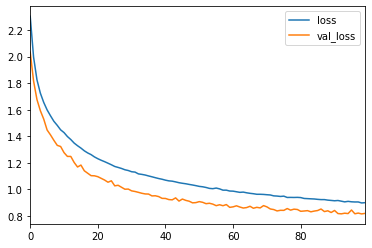

In [32]:
history_df[['loss', 'val_loss']].plot()

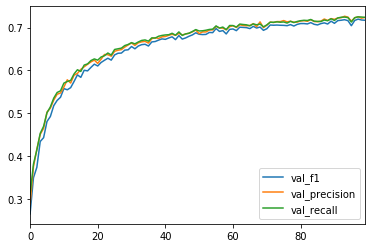

In [33]:
history_df[['val_f1', 'val_precision', 'val_recall']].plot()

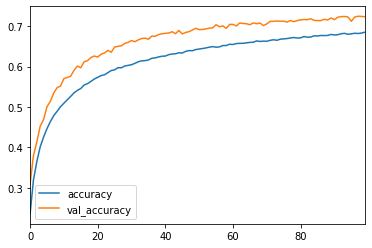

In [36]:
history_df[['accuracy', 'val_accuracy']].plot()

### 5. Prediction

In [37]:
loss,accuracy = model.evaluate(X_test,y_test,)
print('\ntest loss',loss)
print('accuracy',accuracy)

12600/12600 [==============================] - 2s 167us/step

test loss 0.8068679785350013
accuracy 0.7289682626724243
